In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
# from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image

print('setup successful!')

2024-03-25 16:39:26.771365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


setup successful!


In [2]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "../input/garbage-classification/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [3]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [4]:
df.head()

,filename,category
0,metal/metal23.jpg,3
1,plastic/plastic701.jpg,2
2,clothes/clothes2350.jpg,7
3,green-glass/green-glass148.jpg,8
4,paper/paper846.jpg,0


metal/metal137.jpg


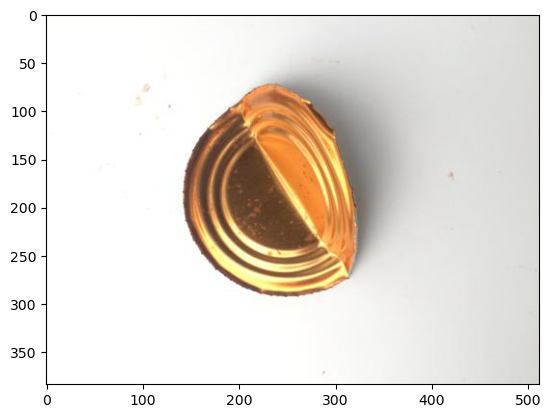

In [5]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

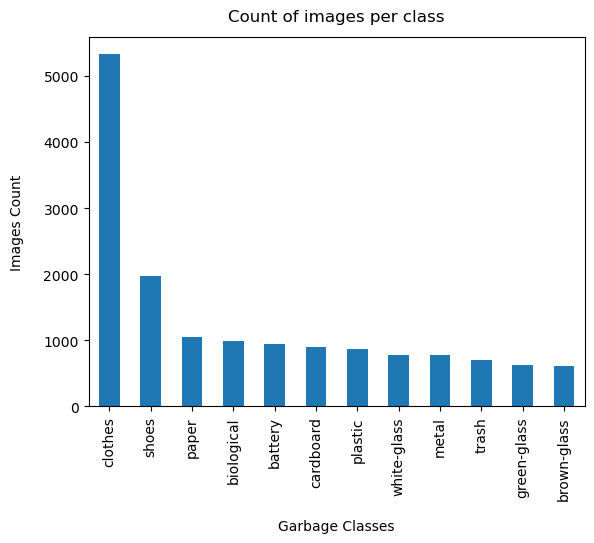

In [6]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [7]:
xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,886,068 (79.67 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [9]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  12412 validate size =  1551 test size =  1552


In [10]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [11]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [14]:
EPOCHS = 1
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1683s 9s/step - categorical_accuracy: 0.9674 - loss: 0.1210 - val_categorical_accuracy: 0.9525 - val_loss: 0.1543


In [15]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [18]:
EPOCHS = 1
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # callbacks=callbacks
)

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9748 - loss: 0.1013

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/193 ━━━━━━━━━━━━━━━━━━━━ 1716s 9s/step - categorical_accuracy: 0.9747 - loss: 0.1013 - val_categorical_accuracy: 0.9531 - val_loss: 0.1504


In [25]:
model.save('trashTwo.keras')
